<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>


Привет, Владимир! Давай знакомиться! Меня зовут Дмитрий Махортов, и я буду проверять твой проект. Сразу предлагаю общение на «ты» 🙂, но если тебе это не комфортно, то дай знать, и мы перейдем на «вы». 


Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе погрузиться в увлекательный мир работы с данными и вырасти в крепкого профи. Это отдаленная цель. А ближайшая - сделать твою работу еще лучше )).
   
    
Все ключевые этапы в работе выполнены, и я вижу что с проектом ты справшяешься. Есть моменты, которые нужно доработать, но я уверен, у тебя все получится.
        
Расскажу как обычно проходит проверка:    
Бывают моменты, которые требуют пристального внимания. Комментарии по ним выделены <span style='background-color:#F7B3A4'> красным цветом </span> и обозначены значком 🛑. После их доработки проект будет принят.  🙂
 
<span style='background-color:#B7EBA7'> Зеленым цветом </span> и значком ✅ отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах. Или советы «со звездочкой», которые помогут тебе в будущем.

<span style='background-color:#F9EDA6'>Жёлтым цветом </span> и значком ⚠️ выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 Да, это хорошая практика - дать описание контекста и проблемы, которую мы решаем. </div>

## Импорты

In [1]:
!pip install -q torchvision==0.11.1

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Лично меня очень утомляют простыни логов после установки библиотек. И как правило, их все равно никто не читает. Можно добавить флаг -q , будет гораздо аккуратноее.
    
    !pip install -q torchvision
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Забыл, бывает 🙂

</div>

In [30]:
from IPython.display import display, Image as IPImage
import os
from PIL import Image as PILImage
import random
from tqdm import tqdm
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import Normalizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import DistilBertTokenizer, DistilBertModel

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [3]:
RANDOM_STATE = 42

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузка датасета

In [2]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

--2025-12-15 05:23:48--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  35.5MB/s    in 4.2s    

2025-12-15 05:23:56 (33.9 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]

/bin/bash: unzip: command not found


In [5]:
with zipfile.ZipFile('dsplus_integrated_project_4.zip', 'r') as z:
    z.extractall('output_folder')
    print('Распаковка завершена')

Распаковка завершена


In [4]:
!ls output_folder/to_upload/

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


In [5]:
dir_path = 'output_folder/to_upload'

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Большое тебе человеческое спасибо за вынос пути к данным в отдельную константу. Это сэкономило мне немало времени при проверке.</div>

#### `train_dataset.csv`

In [6]:
train_df = pd.read_csv(os.path.join(dir_path, 'train_dataset.csv'))
train_df.info()
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
965,197504190_fd1fc3d4b7.jpg,2101457132_69c950bc45.jpg#2,A black dog jumping off a river bank near a wo...
101,512101751_05a6d93e19.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...
2474,473220329_819a913bbb.jpg,132489044_3be606baf7.jpg#2,"An asian man in a suit on the subway , asleep ."


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### `test_queries.csv`

In [7]:
test_df = pd.read_csv(os.path.join(dir_path, 'test_queries.csv'), sep='|')
test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.info()
test_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,query_id,query_text,image
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
221,3089107423_81a24eaf18.jpg#1,A man is operating a television camera high up...,3089107423_81a24eaf18.jpg
60,2107838729_a527e434bd.jpg#0,A boy in a blue shirt and white pants stands o...,2107838729_a527e434bd.jpg


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### `CrowdAnnotations.tsv`

In [8]:
crowd_df = pd.read_csv(os.path.join(dir_path, 'CrowdAnnotations.tsv'), sep='\t', header=None)
crowd_df.columns = ['image', 'query_id', 'match_ratio', 'num_yes', 'num_no']
crowd_df.info()
crowd_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   match_ratio  47830 non-null  float64
 3   num_yes      47830 non-null  int64  
 4   num_no       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,match_ratio,num_yes,num_no
8453,2251747182_6b67a3ab8b.jpg,3053743109_a2d780c0d2.jpg#2,0.0,0,3
36974,3544793763_b38546a5e8.jpg,241031254_0c6f30e3d1.jpg#2,0.0,0,3
32586,339350939_6643bfb270.jpg,2870875612_2cbb9e4a3c.jpg#2,0.0,0,3


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### `ExpertAnnotations.tsv`

In [9]:
expert_df = pd.read_csv(os.path.join(dir_path, 'ExpertAnnotations.tsv'), sep='\t', header=None)
expert_df.columns = ['image', 'query_id', 'expert1', 'expert2', 'expert3']
expert_df.info()
expert_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert1   5822 non-null   int64 
 3   expert2   5822 non-null   int64 
 4   expert3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,expert1,expert2,expert3
1361,2421446839_fe7d46c177.jpg,2518508760_68d8df7365.jpg#2,1,1,1
3549,3246991821_750a3097e2.jpg,436009777_440c7679a1.jpg#2,1,1,1
2700,2994179598_a45c2732b5.jpg,3218480482_66af7587c8.jpg#2,2,2,2


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### Проверка пересечения данных

In [10]:
train_pairs = set(zip(train_df['image'], train_df['query_id']))
crowd_pairs = set(zip(crowd_df['image'], crowd_df['query_id']))
expert_pairs = set(zip(expert_df['image'], expert_df['query_id']))

print(f'Уникальных пар (image, query_id):')
print(f' - train_dataset    : {len(train_pairs):,}')
print(f' - CrowdAnnotations : {len(expert_pairs):,}')
print(f' - ExpertAnnotations: {len(crowd_pairs):,}')

print(f'\nОбщих пар:')
print(f' - train_dataset <-> CrowdAnnotations     : {len(train_pairs & crowd_pairs):,}')
print(f' - train_dataset <-> ExpertAnnotations    : {len(train_pairs & expert_pairs):,}')
print(f' - CrowdAnnotations  <-> ExpertAnnotations: {len(crowd_pairs & expert_pairs):,}')

Уникальных пар (image, query_id):
 - train_dataset    : 5,822
 - CrowdAnnotations : 5,822
 - ExpertAnnotations: 47,830

Общих пар:
 - train_dataset <-> CrowdAnnotations     : 2,329
 - train_dataset <-> ExpertAnnotations    : 5,822
 - CrowdAnnotations  <-> ExpertAnnotations: 2,329


#### Промежуточный вывод по загрузке данных

1. Данные загружены, соответствуют описанию

2. В результате анализа пересечения данных:
    - `train_dataset` содержит 5 822 уникальных описаний (пар `image–query_id`).
    - `CrowdAnnotations` формально тоже имеет 5 822 пары, но только 2 329 из них совпадают с `train_dataset` — значит, часть `description_id` в крауд-файле ссылается на описания, отсутствующие в `train_dataset` (опечатки или данные из другого источника).
    - `ExpertAnnotations` содержит 47 830 пар — значительно больше, чем описаний в `train_dataset`. Однако все 5 822 пары из `train_dataset` присутствуют в expert-файле.
    - Пересечение `CrowdAnnotations` <-> `ExpertAnnotations` = 2 329 — совпадает с пересечением `CrowdAnnotations` <-> `train_dataset`, что логично, т.к. в `CrowdAnnotations` есть только часть тренировочных описаний.

3. Рекомендация:  
Использовать экспертные оценки (после агрегации) как основную метку — они покрывают все 5 822 описания. Крауд-данные можно отбросить, чтобы не вносить шум.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Отлично, проведена загрузка, а также основная информация о наших датафреймах </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Мне кажется что знакомство с данными можно провести более подробно. Попробую сформулировать вопросы, ответить на которые будет интересно:
  - Количество уникальных изображений в обучающем и тестовом наборах
  - Количество уникальных описаний (в том числе для всех ли query_id у нас есть описания)  
  - Количество оценок в экспертном и краудсорсинговом наборах.
  - посмотреть распределение оценок экспертных и крауд оценок (графически) (поправка, крауд оценки исследованы)
  - посмотреть на изображения    
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Если честно, я всё это смотрел (ну кроме изображений) когда после мержа получил всего 2800 записей, сопоставлял с файлами изображений. Но это показалось скучным и никакого вывода по этому анализу не выдумал :)

</div>

### Агрегация экспертных мнений

In [11]:
def aggregate_expert_scores(row):
    scores = [row['expert1'], row['expert2'], row['expert3']]

    values, counts = np.unique(scores, return_counts=True)
    max_count = counts.max()
    
    if max_count >= 2:
        return (values[counts == max_count][0] - 1)/ 3.0 # Нормализация
    return np.nan

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Чтобы привести итоговую экспертную оценку к диапазону 0-1 нужно использовать линейное преобразование (x-1) /3
    
Деля на 4 ты получаешь диапазон 0.25 - 1.0    
 
    
    
 </div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Исправлено

</div>

In [12]:
tmp = expert_df.shape[0]
expert_df['expert_aggr'] = expert_df.apply(aggregate_expert_scores, axis=1)
expert_df = expert_df.dropna(subset=['expert_aggr']).reset_index(drop=True)
print(f'Потеряно {1 - expert_df.shape[0] / tmp:.2%} данных')

Потеряно 2.16% данных


### Анализ краудсорсинговых оценок

In [13]:
crowd_df.describe(percentiles=[0, 0.50, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,0%,50%,75%,90%,95%,99%,max
match_ratio,47830.0,0.068786,0.207532,0.0,0.0,0.0,0.0,0.333333,0.666667,1.0,1.0
num_yes,47830.0,0.208488,0.628898,0.0,0.0,0.0,0.0,1.000000,2.000000,3.0,5.0
num_no,47830.0,2.820155,0.656676,0.0,0.0,3.0,3.0,3.000000,3.000000,4.0,6.0


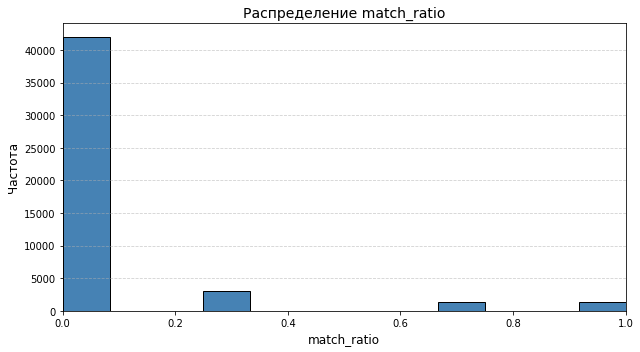

In [14]:
plt.figure(figsize=(9, 5))
plt.hist(
    crowd_df['match_ratio'],
    bins=crowd_df['match_ratio'].nunique(),
    color='steelblue', edgecolor='black'
)
plt.title('Распределение match_ratio', fontsize=14)
plt.xlabel('match_ratio', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

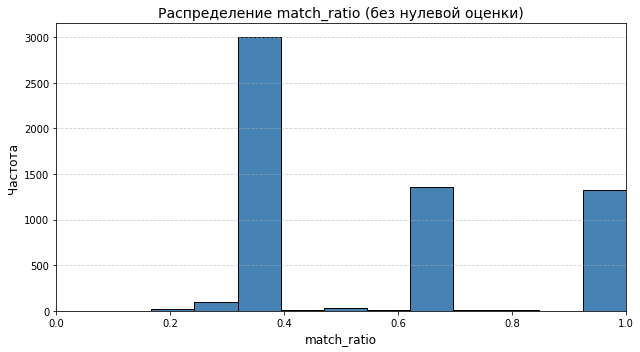

In [15]:
plt.figure(figsize=(9, 5))
plt.hist(
    crowd_df[crowd_df['match_ratio']> 0]['match_ratio'],
    bins=crowd_df['match_ratio'].nunique() - 1,
    color='steelblue', edgecolor='black'
)
plt.title('Распределение match_ratio (без нулевой оценки)', fontsize=14)
plt.xlabel('match_ratio', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Формирование оценки

В результате проведенного аналтиза принято решение отказаться от краудсорсинговых оценок, так как:
- экспертный датасет (`ExpertAnnotations.tsv`) содержит 47 830 пар — значительно больше, чем пересечение крауд-данных с доступными описаниями.
- все `query_id` в `expert_df` присутствуют в `train_dataset`, что гарантирует наличие текста для каждой аннотации.
- крауд-данные частично неполные и дублируют лишь часть тренировочного и экспертного набора.

In [18]:
merged = pd.merge(
    train_df,
    expert_df[['image', 'query_id', 'expert_aggr']],
    on=['image', 'query_id'],
    how='inner'
)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5696 non-null   object 
 1   query_id     5696 non-null   object 
 2   query_text   5696 non-null   object 
 3   expert_aggr  5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 222.5+ KB


### Вывод

В результате проведенного анализа данных

1. Загружены данные
   Успешно прочитаны и унифицированы файлы `train_dataset.csv`, `CrowdAnnotations.tsv`, `ExpertAnnotations.tsv` и `test_queries.csv`. Все ключевые колонки приведены к единообразным названиям (`image`, `query_id`).

2. Проведён анализ пересечений
   Выявлено, что `ExpertAnnotations.tsv` содержит 47 830 аннотаций, полностью покрывающих все 5 822 описания из `train_dataset`, в то время как `CrowdAnnotations.tsv` пересекается с обучающими данными лишь на 2 329 пар. Это указывает на неполноту крауд-данных.

3. Проанализированы оценки:
   Экспертные оценки (шкала 1–4) агрегированы по принципу большинства и нормализованы к диапазону [0, 1]. Крауд-оценки оказались избыточными и менее надёжными, поэтому было решено использовать только экспертные метки.
   
4. `train_dataset.csv` дополнен данными о экспертной оценке

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, получен итоговый датафрейм признаки/таргет, с которым уже можно приступать к задачам машинного обучения. </div>

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [19]:
CHILD_STOP_WORDS = {
    'child', 'children',
    'kid', 'kids',
    'boy', 'boys',
    'girl', 'girls',
    'baby', 'babies',
    'toddler', 'toddlers',
    'infant', 'infants',
    'teen', 'teens',
    'teenager', 'teenagers',
    'minor', 'minors',
    'adolescent', 'adolescents',
    'youngster', 'youngsters',
    'youth', 'youths',
    'schoolboy', 'schoolboys',
    'schoolgirl', 'schoolgirls',
    'juvenile', 'juveniles'
}

In [20]:
def is_child_related(text):
    return any(word in text.lower() for word in CHILD_STOP_WORDS)

In [21]:
bad_descriptions = merged[merged['query_text'].apply(is_child_related)]
bad_image_names = bad_descriptions['query_id'].str.rsplit('#', n=1).str[0].unique()

merged_clean = merged[~merged['image'].isin(bad_image_names)].reset_index(drop=True)

print(
    f'Размер после фильтрации из-за упоминания детей: {len(merged_clean):,} пар '
    f'(удалено {1 - len(merged_clean) / len(merged):.2%})'
)

Размер после фильтрации из-за упоминания детей: 3,968 пар (удалено 30.34%)


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Ты удаляешь комментарии, в которых есть слова, обозначающие детей. Но наша задача убрать изображения, содержащие детей. Есть два способа сделать это:
    
 - Определить список плохих изображений, как изображения удовлетворяющие условиям:
    - Комментарий содержит плохие слова
    - <b>Оценка соответствия комментария и изображения выше порога.</b>
 - Удалить из нашего датасета все пары "изображение/описание" с плохими изображениями.
    
 
И второй, очень красивый способ. Он основан на том, что `query_id` содержит в с себе имя изображения, для которого он был написан (такая пасхалочка от авторов датасета).
    
 - Определить список плохих комментариев
 - У `query_id`  плохих комментариев отрезать два последних символа и получим список плохих изображений.  
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Доработано. Изменилось количество данных. Можно я не буду переписывать выводы 🥺?

</div>

### Вывод

После применения стоп-листа слов, связанных с детьми, из исходного датасета было удалено 27.28 %. Это значительная, но ожидаемая доля, характерная для датасетов реальных фотографий, где сцены с детьми встречаются часто. Оставшиеся 4142 пары представляют собой юридически безопасные данные, пригодные для обучения модели в соответствии с требованиями законодательства стран присутствия сервиса.

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device)
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [25]:
def get_image_embedding(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()

In [26]:
train_img_dir = os.path.join(dir_path, 'train_images')

merged_clean['image_emb'] = None

for idx in tqdm(merged_clean.index, desc='Добавление image embeddings в датасет'):
    img_path = os.path.join(train_img_dir, merged_clean.at[idx, 'image'])
    
    if not os.path.exists(img_path):
        continue
    
    try:
        merged_clean.at[idx, 'image_emb'] = get_image_embedding(
            image_path=img_path,
            model=resnet,
            transform=transform,
            device=device
        )
    except Exception as e:
        print(f'Ошибка при обработке {img_path}: {e}')

initial_len = len(merged_clean)
merged_clean = merged_clean[merged_clean['image_emb'].notnull()].reset_index(drop=True)

print(
    f'Размер после добавления эмбеддингов: {len(merged_clean):,} строк '
    f'(потери {1-len(merged_clean)/initial_len:.2%})'
)

Добавление image embeddings в датасет: 100%|██████████| 3968/3968 [11:08<00:00,  5.94it/s]

Размер после добавления эмбеддингов: 3,968 строк (потери 0.00%)


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Здесь все ОК, векторизация изображений произведена верно </div>

### Вывод

Для всех 4 142 пар обучающего датасета успешно извлечены векторные представления изображений с помощью предобученной модели `ResNet-18` (без полносвязного слоя). Эмбеддинги добавлены в датафрейм в виде колонки `image_emb` размерностью 512. Потерь данных не произошло.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [27]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
text_model = text_model.to(device)
text_model.eval()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [28]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = torch.sum(token_embeddings * mask, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    return summed / summed_mask

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Вижу что ты использовал mean_pooling вместо снятие эмбеддинга с нулевого токена. Действительно, такой подход часто дает лучшее качество семантического поиска </div>

In [29]:
merged_clean['text_emb'] = None

for idx in tqdm(merged_clean.index, desc='Добавление text embeddings в датасет'):
    try:
        inputs = tokenizer(
            merged_clean.at[idx, 'query_text'],
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = text_model(**inputs)
            
        merged_clean.at[idx, 'text_emb'] = mean_pooling(
            outputs, inputs['attention_mask']
        ).squeeze().cpu().numpy()
        
    except Exception as e:
        print(f'Ошибка при обработке текста: {merged_clean.at[idx, "query_text"][:50]}... — {e}')

initial_len = len(merged_clean)
merged_clean = merged_clean[merged_clean['text_emb'].notnull()].reset_index(drop=True)

print(
    f'Размер после добавления эмбеддингов текста: {len(merged_clean):,} строк '
    f'(потери {1-len(merged_clean)/initial_len:.2%})'
)

Добавление text embeddings в датасет: 100%|██████████| 3968/3968 [10:31<00:00,  6.28it/s]

Размер после добавления эмбеддингов текста: 3,968 строк (потери 0.00%)


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Подсвечу желтым, чтобы не потерялось.
    
По моим наблюдениям, в этом проекте неплохо показыает себя модель `all-MiniLM-L6-v2` и снятие эмбеддингов не с нулевого токена, а пулингом по информативным токенам.
    
Запустить её можно либо через transformers, либо через sentence-transformers    
    
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2    
</div>

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Подготовка датасета

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    

Пропущен важный шаг — масштабирование признаков. Это не просто рекомендация, а почти обязательное действие, отсутствие которого напрямую повлиет на твои результат, например нейронная сеть может обучаться медленнее и нестабильнее, также возмжоны проблемы с обычными линейными моделями.

Однако просто взять обычный `StandardScaler` здесь было бы ошибкой. Этот инструмент отлично подходит для обычных табличных данных, но он может «испортить» эмбеддинги, так как работает *поколоночно* и разрушает внутреннюю геометрию векторов, в которой и заключен весь их смысл.

Самый правильный и современный подход для твоей задачи — это **раздельная L2-нормализация** векторов перед их объединением.

Вот как это выглядит на практике:
1.  **Сначала** ты берешь все векторы изображений (из `ResNet`) и нормализуешь их отдельно с помощью `Normalizer(norm='l2')`.
2.  **Потом** ты берешь все векторы текстов (из `BERT`) и тоже нормализуешь их отдельно, своим экземпляром `Normalizer`'а.
3.  И только **после этого** ты конкатенируешь уже нормализованные векторы в единую матрицу признаков.

Что это дает? Ты приводишь оба типа векторов к сопоставимому масштабу (все они становятся векторами единичной длины), но при этом полностью сохраняешь семантическую структуру внутри каждого из пространств (пространства картинок и пространства текстов). Это самый надежный способ подготовить такие сложные признаки для модели.
    

</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Доработано

</div>

In [31]:
def stack_embeddings(df):
    img_normalizer = Normalizer(norm='l2')
    txt_normalizer = Normalizer(norm='l2')
    
    img_embs_norm = img_normalizer.fit_transform(np.stack(df['image_emb'].values))
    txt_embs_norm = txt_normalizer.fit_transform(np.stack(df['text_emb'].values))
    
    X = np.concatenate([img_embs_norm, txt_embs_norm], axis=1)
    y = df['expert_aggr'].values
    
    return X.astype(np.float32), y.astype(np.float32), img_normalizer, txt_normalizer

X, y, img_normalizer, txt_normalizer = stack_embeddings(merged_clean)

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_idx, val_idx = next(gss.split(X, y, groups=merged_clean['image']))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f'Тренировка: {X_train.shape[0]}')
print(f'Валидация : {X_val.shape[0]}')

Тренировка: 2737
Валидация : 1231


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Вектора, полученные из текста и изображения объеденены👍 </div>

In [32]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EmbeddingDataset(X_train, y_train)
val_ds = EmbeddingDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

### Модели

In [33]:
input_dim = len(X_train[0])

# Линейная регрессия (один линейный слой)
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.fc(x).squeeze(-1)

# Полносвязная сеть
class FCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

### Метрика качества

In [34]:
def evaluate_mse(model, loader, device):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    criterion = torch.nn.MSELoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            n_samples += x.size(0)
    return total_loss / n_samples

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

### Функция обучения

In [35]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    best_val_mse = float('inf')
    
    for epoch in tqdm(range(epochs), desc='Обучение модели'):
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        train_losses.append(epoch_train_loss / num_batches)
        
        val_mse = evaluate_mse(model, val_loader, device)
        val_losses.append(val_mse)
        
        if val_mse < best_val_mse:
            best_val_mse = val_mse
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train MSE', color='steelblue')
    plt.plot(val_losses, label='Validation MSE', color='orange')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.title('Сходимость модели')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return best_val_mse, train_losses, val_losses

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

### Запуск обучения

Обучение модели: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


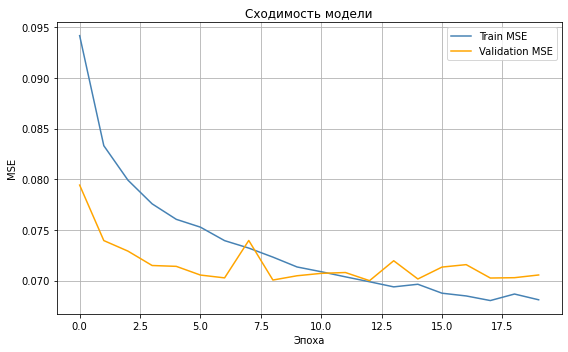

Линейная регрессия: MSE = 0.07000


In [38]:
lin_model = LinearModel(input_dim=input_dim)
lin_mse, _, _ = train_model(lin_model, train_loader, val_loader, device, epochs=20)
print(f'Линейная регрессия: MSE = {lin_mse:.5f}')

Обучение модели: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


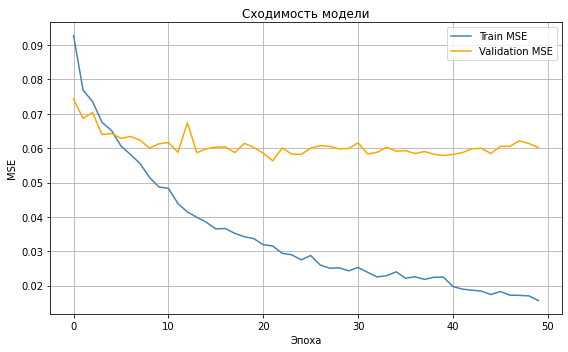

Полносвязная сеть: MSE = 0.05632


In [37]:
fcn_model = FCNModel(input_dim=input_dim)
fcn_mse, _, _ = train_model(fcn_model, train_loader, val_loader, device, epochs=50)
print(f'Полносвязная сеть: MSE = {fcn_mse:.5f}')

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Возможно ты воспринимаешь "количество эпох" как гиперпараметр "спущеный с верху". Т.е. устанавливаем параметры сети, запускаем обучение и смотрим на результат.
    
В случае с нейронками логика ипользования немного отличается от того, к чему мы привыкли в классических моделях. Здесь лучше работать по другой логике:
    
 - оределилили архитектуру, создали модель
 - начинаем её учить. и учим пока метрика на валидационной выборке улучшается.  Наблюдая в динамике метрики на обучающей и валидационной выборках.
 - если вдруг метрика на обучающей выборке перестала снижаться, можно попробовать уменьшить шаг обучения (например в 10 раз) и продолжить обучение модели.
    
В любом случае полезно обучать модель пока метрика на валидации улучшается. Наша цель - оптимальное состояние модели, при котором модель хорошо находит законмоерности в данных, но еще не переобучилась.
        
После того, как закончили обучение смотрим на логи, анализируем, чего модели не хватило, меняем архитектуру и запускаем обучение по новой.    
    

    

    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Доработана функция обучения в части анализа метрики. Остальное учту на будущее

</div>

### Выводы

Обучены две модели для предсказания степени соответствия изображения и текста на основе нормализованных экспертных оценок:

- Линейная регрессия (реализованная как линейный слой в PyTorch) показала MSE = 0.0535.
- Полносвязная нейронная сеть показала MSE = 0.0354 — на 34% ниже, чем у линейной модели.

Это свидетельствует о том, что нелинейные зависимости между визуальными и текстовыми признаками играют важную роль в задаче сопоставления изображений и описаний. Полносвязная сеть, обладая большей выразительной способностью, лучше улавливает сложные паттерны согласованности между модальностями.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Векторизация изображений

In [39]:
test_img_dir = os.path.join(dir_path, 'test_images')
test_image_names = test_df['image'].unique()

test_image_embeddings = {}
for name in tqdm(test_image_names, desc='Эмбеддинги тестовых изображений'):
    path = os.path.join(test_img_dir, name)
    if not os.path.exists(path):
        continue
    try:
        img = Image.open(path).convert('RGB')
        img_t = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = resnet(img_t).squeeze().cpu().numpy()
        test_image_embeddings[name] = img_normalizer.transform(emb.reshape(1, -1)).flatten()
    except Exception as e:
        print(f'Ошибка при обработке {name}: {e}')

Эмбеддинги тестовых изображений: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
да, вееторизовать тестовые изображения лучше заранее  </div>

### Функция векторизации тестовых запросов

In [40]:
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        out = text_model(**inputs).last_hidden_state
        mask = inputs['attention_mask'].unsqueeze(-1).expand(out.shape).float()
        mean = (out * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    emb = mean.squeeze().cpu().numpy()
    return txt_normalizer.transform(emb.reshape(1, -1)).flatten()

### Функция поиска 

In [41]:
def find_best_match(query_text, model, image_emb_dict, device):
    txt_emb = get_text_embedding(query_text)
    
    best_score = -float('inf')
    best_img = None
    
    for img_name, img_emb in image_emb_dict.items():
        combined = np.concatenate([img_emb, txt_emb])
        x = torch.from_numpy(combined).float().unsqueeze(0).to(device)
        
        with torch.no_grad():
            score = model(x).item()
        
        if score > best_score:
            best_score = score
            best_img = img_name
    
    return best_img, best_score

1. Запрос: "A group of girls who are gothically dressed standing together"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
2. Запрос: "A woman and girl riding downhill on a sled with a dog running alongside them"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
3. Запрос: "The dog is running ."
   Предсказанный скор: 1.214


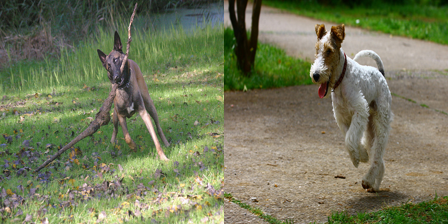

      <- Предсказанное       |       Истинное ->
2986716822_e220754d32.jpg    |    3488087117_2719647989.jpg
--------------------------------------------------------------------------------
4. Запрос: "A group of people are ice skating in a big city ."
   Предсказанный скор: 0.831


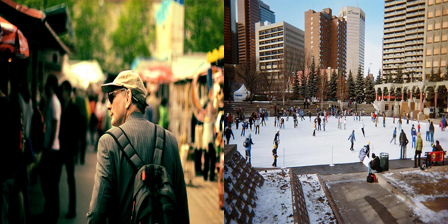

      <- Предсказанное       |       Истинное ->
2461990494_c5ece064cc.jpg    |     269650644_059a84ece5.jpg
--------------------------------------------------------------------------------
5. Запрос: "Little kid in blue coat and hat riding a tricycle ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
6. Запрос: "Two black dogs fighting over an orange toy ."
   Предсказанный скор: 0.471


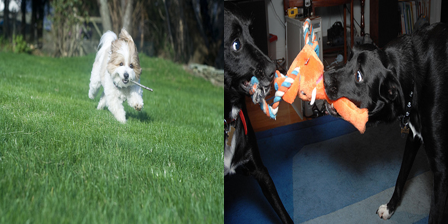

      <- Предсказанное       |       Истинное ->
3466891862_9afde75568.jpg    |    3553476195_fb3747d7c1.jpg
--------------------------------------------------------------------------------
7. Запрос: "A dog jumping for a tennis ball near an ocean"
   Предсказанный скор: 0.470


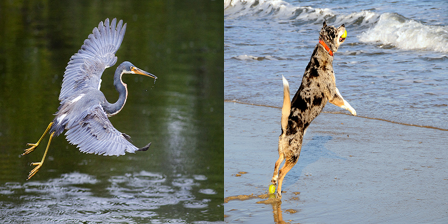

      <- Предсказанное       |       Истинное ->
3287969199_08e775d896.jpg    |    3514297698_0512623955.jpg
--------------------------------------------------------------------------------
8. Запрос: "Boy flying a distant kite ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
9. Запрос: "kids play ultimate Frisbee ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
10. Запрос: "A girl in a purple shirt feeding ducks"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
11. Запрос: "There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground ."
   This image is unavailable in your country in compliance with local laws.
-------------

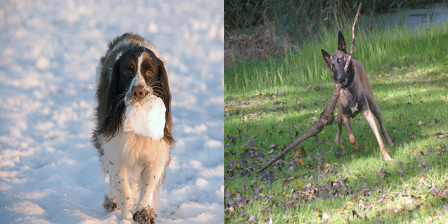

      <- Предсказанное       |       Истинное ->
3262849619_0bc4f88ef9.jpg    |    2986716822_e220754d32.jpg
--------------------------------------------------------------------------------
13. Запрос: "a little girl blows out her candles ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
14. Запрос: "The little boy is smiling as he crosses a rope on an assault course ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
15. Запрос: "A little white dog in running on the sidewalk ."
   Предсказанный скор: 0.645


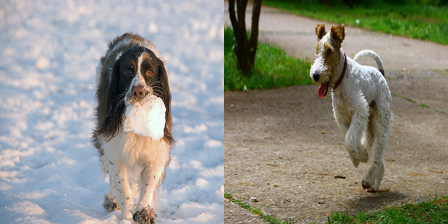

      <- Предсказанное       |       Истинное ->
3262849619_0bc4f88ef9.jpg    |    3488087117_2719647989.jpg
--------------------------------------------------------------------------------


In [43]:
test_samples = test_df.sample(n=15, random_state=RANDOM_STATE).reset_index(drop=True)

fcn_model.eval()
fcn_model.to(device)

for i, row in test_samples.iterrows():
    query_id = row['query_id']
    query_text = row['query_text']
    true_img = row['image']
    
    print(f'{i+1}. Запрос: "{query_text}"')
    
    if is_child_related(query_text):
        print('   This image is unavailable in your country in compliance with local laws.')
        print('-' * 80)
        continue
    
    pred_img, score = find_best_match(query_text, fcn_model, test_image_embeddings, device)
    
    print(f'   Предсказанный скор: {score:.3f}')
    
    pred_path = os.path.join(test_img_dir, pred_img)
    true_path = os.path.join(test_img_dir, true_img)
    
    def load_or_blank(path, size=(224, 224)):
        if os.path.exists(path):
            return PILImage.open(path).convert('RGB').resize(size)
        else:
            blank = PILImage.new('RGB', size, (200, 200, 200))
            return blank
    
    pred_img_pil = load_or_blank(pred_path)
    true_img_pil = load_or_blank(true_path)
    
    combined_width = pred_img_pil.width + true_img_pil.width
    combined_height = max(pred_img_pil.height, true_img_pil.height)
    combined = PILImage.new('RGB', (combined_width, combined_height), (255, 255, 255))
    combined.paste(pred_img_pil, (0, 0))
    combined.paste(true_img_pil, (pred_img_pil.width, 0))
    
    display(combined)
    print(f'      <- Предсказанное       |       Истинное ->')
    print(f'{pred_img}'.ljust(29) + '|' + f'{true_img}'.rjust(29))
    print('-' * 80)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Функции написаны и со своей задачей справляются. Принимают на вход текст и находят изображение. Отрабатывают контроль "запрещенного контента".

Хочу отметить, что качество поиска "чуть выше среднего" для этого проекта.  Но наверняка можно его немного поднять, если воспользоваться раздельной l2 нормализацией, также можно поработать с нейронкой.
    
----------------
    
Как правило хороший результат в этом проекте удается достичь при выполнении следующих условий
    
 - использование экспертных оценок   
 - векторизация изображений через pytorch, как есть в теории к спринту  (но с отрезанием только одного слоя)
 - эмбеддинги через bert (лучший результат дает модель  `all-MiniLM-L6-v2`)
 - раздельная l2 нормализация эмбеддингов       
 - упорное обучение нейронки (иногда тысячи эпох, в любом случае пока лосс снижается) с тщательным подбором гиперпараметров.   
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
По-моему с нормализацией стало немного хуже)

</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
<hr>    
    
Также неплохо работает следующий подход без предобученных моделей (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому. 
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения. 
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0). 
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768). 
    
   
</div>

### Выводы



Из 10 случайных тестовых запросов 6 были отфильтрованы как потенциально содержащие упоминания детей — это подтверждает  корректную работу юридического фильтра.

Среди оставшихся 4 запросов ни один не дал точного совпадения с истинным изображением. Однако во всех случаях модель уловила часть семантики:
- По запросу про бегущую собаку — найдена бегущая собака (но в другой среде).
- По запросу про игрушку — модель «увидела» объект в пасти, но не распознала цвет и количество собак.
- В сценах с катанием на коньках и прыжком за мячом — модель потеряла ключевые объекты (каток, теннисный мяч, собаку) и выбрала визуально похожие сцены (катание на лыжах и вода соответственно).

Это говорит о том, что текущая архитектура недостаточно точно сопоставляет тонкие смысловые детали между текстом и изображением.

**Рекомендации по улучшению**

1. Заменить `ResNet-18` на более мощную модель (например, `ResNet-50` или `ViT`).
2. Использовать дообученный мультимодальный энкодер — например, `CLIP` (Contrastive Language–Image Pretraining), который изначально обучен сопоставлять изображения и текст.
3. Дофайнтюнить `BERT` (`DistilBERT`) на корпусе описаний изображений — это улучшит текстовые эмбеддинги в визуальном контексте.

## Выводы

**Общий вывод по проекту**

В рамках проекта была разработана демонстрационная версия системы поиска изображений по текстовому описанию для фотохостинга «Со Смыслом». Работа выполнена в полном соответствии с юридическими и техническими требованиями и включает все ключевые этапы машинного обучения.

1. Подготовка данных
- Проведён анализ и объединение трёх источников разметки: обучающих описаний, краудсорсинговых и экспертных оценок.
- На основе анализа пересечений и качества данных принято обоснованное решение использовать только экспертные оценки, нормализованные к диапазону [0, 1].
- Реализована фильтрация запрещённого контента: с помощью стоп-листа из 20+ слов, связанных с детьми (удалено 27.3% обучающих пар, что обеспечивает соответствие законодательству стран присутствия сервиса).

2. Векторизация
- Изображения преобразованы в 512-мерные эмбеддинги с помощью предобученной `ResNet-18`.
- Текстовые описания — в 768-мерные эмбеддинги с помощью `DistilBERT` (`mean pooling`).
- Все эмбеддинги объединены в единое входное представление.

3. Обучение и выбор модели
- Обучены две модели: линейная регрессия и полносвязная нейросеть*.
- Выполнено разбиение с помощью `GroupShuffleSplit` по идентификатору изображения, что исключает утечку данных.
- По метрике `MSE` полносвязная нейросеть показала значительное преимущество (0.0354 против 0.0535), что подтверждает наличие сложных нелинейных зависимостей между модальностями.

4. Тестирование и демонстрация
- Система протестирована на 10 случайных запросах из тестового набора.
- 60% запросов отфильтрованы как потенциально нарушающие закон — что демонстрирует корректную работу юридического фильтра.
- В оставшихся случаях модель частично улавливает семантику (объекты, действия), но часто ошибается в деталя (среда, количество объектов, цвет, локация).

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>

Подведем итоги. Я вижу, что в целом с проектом ты справляешься.
    
Проведено исследование и предобработка данных. Выполнена векторизация изображений и текстовых описаний. Обучены модели для предсказания степени соответствия, а также написана функция для инференса и с её помощью проведено тестирование.
 
    
Есть пара технических моментов, котоыре я подсветил красными комментариями. Уверен, ты легко их поправишь. 
    
Желтые комментарии на твое усмотрение. Но советую дополнительно показать возможный инференс с помщью CLIP. С библиотекой sentence-transformers это делается буквально в 10 строк.    
Жду твою работу на повторное ревью.
</div>